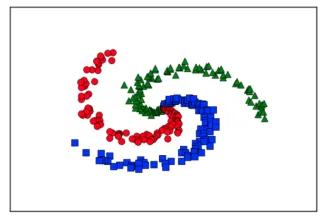

In [ ]:
!gdown 1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V

Downloading...
From: https://drive.google.com/uc?id=1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V
To: /content/NonLinear_data.npy
100% 5.57k/5.57k [00:00<00:00, 8.97MB/s]


In [ ]:
# 2. Read dataset
path_dataset = '/content/NonLinear_data.npy'
data = np.load(path_dataset , allow_pickle = True ).item()
X, y = data['X'], data['labels']
data.keys, type(data) , X.shape , y. shape

(<function dict.keys>, dict, (300, 2), (300,))

Data shapes: (300, 2) (300,)


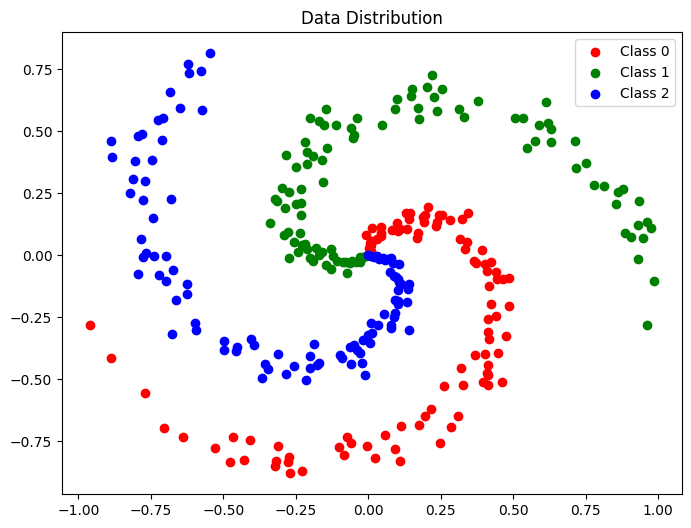

Epoch 10:	Train loss: 0.453	Val loss: 0.332
		Train acc: 0.833	Val acc: 0.917
Epoch 20:	Train loss: 0.444	Val loss: 0.283
		Train acc: 0.833	Val acc: 0.867
Epoch 30:	Train loss: 0.377	Val loss: 0.204
		Train acc: 0.886	Val acc: 0.933
Epoch 40:	Train loss: 0.260	Val loss: 0.197
		Train acc: 0.905	Val acc: 0.933
Epoch 50:	Train loss: 0.271	Val loss: 0.170
		Train acc: 0.905	Val acc: 0.950
Epoch 60:	Train loss: 0.268	Val loss: 0.162
		Train acc: 0.910	Val acc: 0.933
Epoch 70:	Train loss: 0.289	Val loss: 0.141
		Train acc: 0.876	Val acc: 0.967
Epoch 80:	Train loss: 0.245	Val loss: 0.135
		Train acc: 0.910	Val acc: 0.983
Epoch 90:	Train loss: 0.390	Val loss: 0.127
		Train acc: 0.867	Val acc: 0.983
Epoch 100:	Train loss: 0.256	Val loss: 0.152
		Train acc: 0.890	Val acc: 0.950


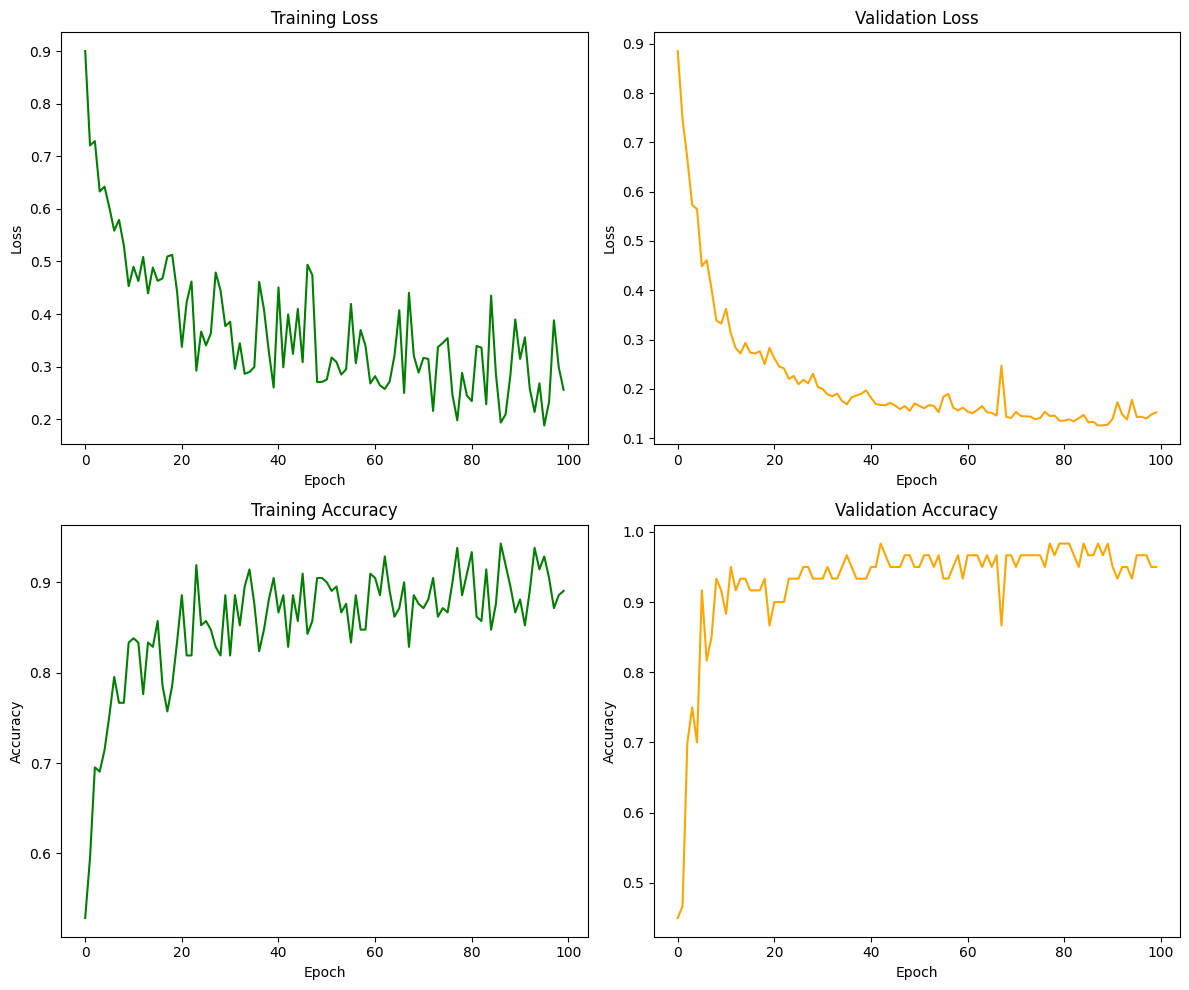

Evaluation on test set:
Accuracy: 0.9000


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Set environment
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

# 2. Load data
data_path = '/content/NonLinear_data.npy'
data = np.load(data_path, allow_pickle=True).item()
X, y = data['X'], data['labels']
print("Data shapes:", X.shape, y.shape)  # Should print (300, 2) (300,)

# 3. Visualization before preprocessing
plt.figure(figsize=(8, 6))
colors = ['red', 'green', 'blue']
for i in range(3):
    mask = y == i
    plt.scatter(X[mask, 0], X[mask, 1], c=colors[i], label=f'Class {i}')
plt.title('Data Distribution')
plt.legend()
plt.show()

# 4. Split data
val_size = 0.2
test_size = 0.125
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                 test_size=val_size,
                                                 random_state=random_state,
                                                 shuffle=True)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                   test_size=test_size,
                                                   random_state=random_state,
                                                   shuffle=True)

# 5. Standardize features
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

# Convert to PyTorch tensors with correct dtypes
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)  # Use long for classification
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# 6. Create Dataset and DataLoader
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X  # Features (x1, x2)
        self.y = y  # Labels (0, 1, 2)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create data loaders
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 7. Define improved MLP model for nonlinear classification
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.batch_norm1 = nn.BatchNorm1d(hidden_dims)
        self.dropout1 = nn.Dropout(0.3)

        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.batch_norm2 = nn.BatchNorm1d(hidden_dims)
        self.dropout2 = nn.Dropout(0.3)

        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        # First layer with BatchNorm and Dropout
        x = self.linear1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        # Second layer with BatchNorm and Dropout
        x = self.linear2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        # Output layer (no activation needed before CrossEntropyLoss)
        out = self.output(x)
        return out

# 8. Initialize model and training components
input_dims = X_train.shape[1]  # 2
output_dims = len(torch.unique(y_train))  # 3 classes
hidden_dims = 128  # Larger network for nonlinear data

model = MLP(input_dims=input_dims,
           hidden_dims=hidden_dims,
           output_dims=output_dims).to(device)

# 9. Define loss and optimizer
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# 10. Define accuracy computation
def compute_accuracy(y_hat, y_true):
    """
    Compute classification accuracy
    y_hat: model predictions
    y_true: ground truth labels
    """
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

# 11. Training loop with improved monitoring
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_target = []
    train_predict = []

    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)

        optimizer.zero_grad()
        outputs = model(X_samples)

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_target = []
    val_predict = []

    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)

            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}:\tTrain loss: {train_loss:.3f}\tVal loss: {val_loss:.3f}')
        print(f'\t\tTrain acc: {train_acc:.3f}\tVal acc: {val_acc:.3f}')

# 12. Plot training results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(train_losses, color='green')
axes[0, 0].set(xlabel='Epoch', ylabel='Loss')
axes[0, 0].set_title('Training Loss')

axes[0, 1].plot(val_losses, color='orange')
axes[0, 1].set(xlabel='Epoch', ylabel='Loss')
axes[0, 1].set_title('Validation Loss')

axes[1, 0].plot(train_accs, color='green')
axes[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
axes[1, 0].set_title('Training Accuracy')

axes[1, 1].plot(val_accs, color='orange')
axes[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
axes[1, 1].set_title('Validation Accuracy')

plt.tight_layout()
plt.show()

# 13. Evaluate on test set
test_target = []
test_predict = []
model.eval()

with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = compute_accuracy(test_predict, test_target)

print('Evaluation on test set:')
print(f'Accuracy: {test_acc:.4f}')

# ***Visualization decision boundary***

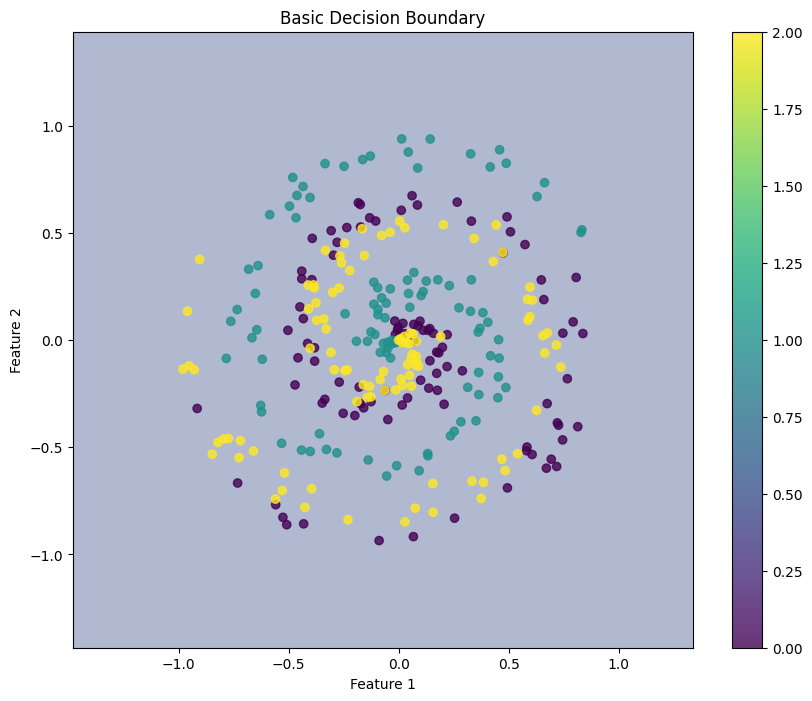

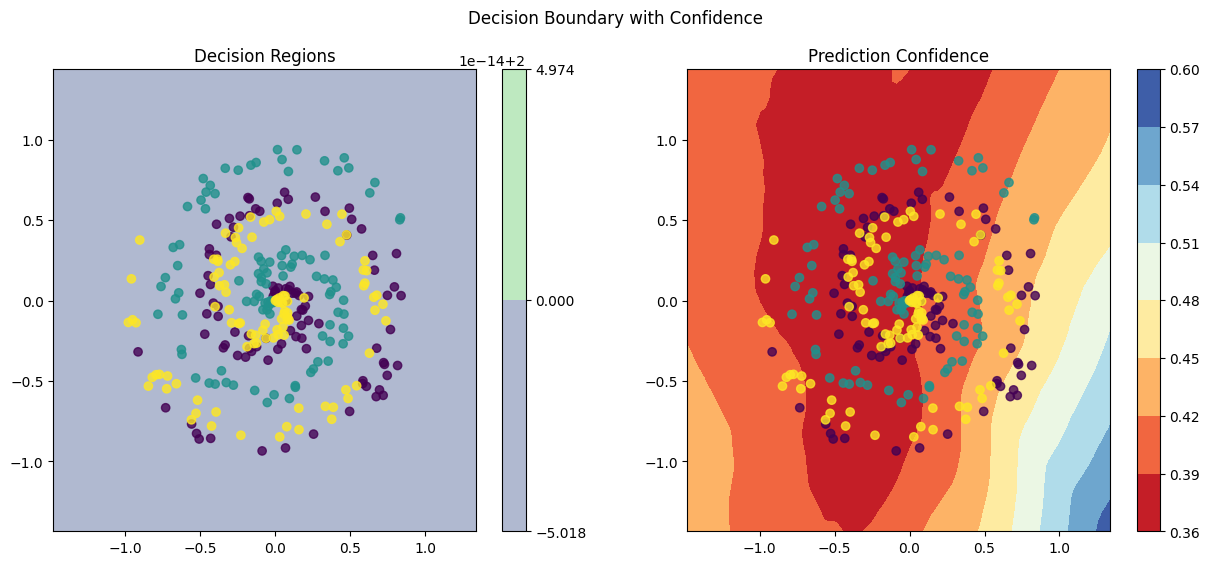

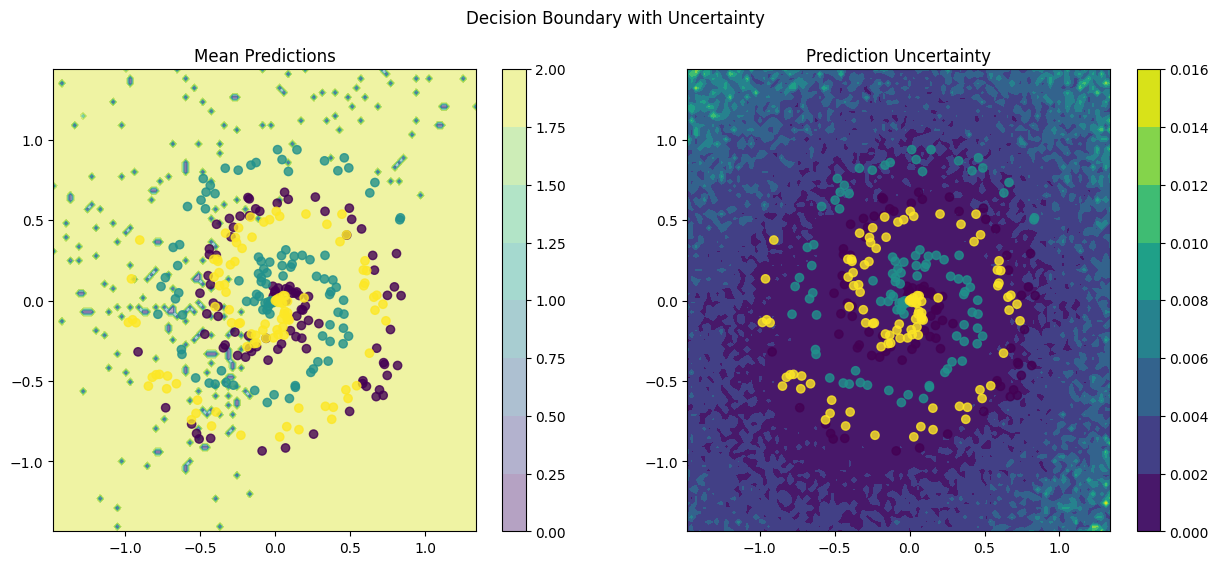

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

class DecisionBoundaryPlotter:
    def __init__(self, model, scaler=None):
        self.model = model
        self.scaler = scaler

    def create_mesh_grid(self, X, padding=0.5, resolution=100):
        """Create mesh grid for plotting"""
        x_min, x_max = X[:, 0].min() - padding, X[:, 0].max() + padding
        y_min, y_max = X[:, 1].min() - padding, X[:, 1].max() + padding

        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, resolution),
            np.linspace(y_min, y_max, resolution)
        )
        return xx, yy

    def predict_mesh(self, xx, yy):
        """Get predictions for all mesh points"""
        # Flatten mesh points
        mesh_points = np.c_[xx.ravel(), yy.ravel()]

        # Scale if scaler exists
        if self.scaler:
            mesh_points = self.scaler.transform(mesh_points)

        # Convert to tensor and get predictions
        mesh_tensor = torch.FloatTensor(mesh_points)
        self.model.eval()

        with torch.no_grad():
            predictions = self.model(mesh_tensor)
            _, predicted = torch.max(predictions, 1)

        # Reshape predictions back to grid
        return predicted.numpy().reshape(xx.shape)

    def plot_basic(self, X, y, title="Basic Decision Boundary"):
        """Plot basic decision boundary"""
        xx, yy = self.create_mesh_grid(X)
        Z = self.predict_mesh(xx, yy)

        plt.figure(figsize=(10, 8))
        plt.contourf(xx, yy, Z, alpha=0.4)
        plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
        plt.title(title)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.colorbar()
        plt.show()

    def plot_confidence(self, X, y, title="Decision Boundary with Confidence"):
        """Plot decision boundary with prediction confidence"""
        xx, yy = self.create_mesh_grid(X)
        mesh_points = np.c_[xx.ravel(), yy.ravel()]

        if self.scaler:
            mesh_points = self.scaler.transform(mesh_points)

        mesh_tensor = torch.FloatTensor(mesh_points)
        self.model.eval()

        with torch.no_grad():
            predictions = torch.softmax(self.model(mesh_tensor), dim=1)
            confidence, predicted = torch.max(predictions, 1)

        # Reshape predictions and confidence
        Z = predicted.numpy().reshape(xx.shape)
        C = confidence.numpy().reshape(xx.shape)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Plot decision regions
        im1 = ax1.contourf(xx, yy, Z, alpha=0.4)
        ax1.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
        ax1.set_title('Decision Regions')
        plt.colorbar(im1, ax=ax1)

        # Plot confidence
        im2 = ax2.contourf(xx, yy, C, cmap='RdYlBu')
        ax2.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
        ax2.set_title('Prediction Confidence')
        plt.colorbar(im2, ax=ax2)

        plt.suptitle(title)
        plt.show()

    def plot_uncertainty(self, X, y, n_samples=10, title="Decision Boundary with Uncertainty"):
        """Plot decision boundary with model uncertainty using MC Dropout"""
        xx, yy = self.create_mesh_grid(X)
        mesh_points = np.c_[xx.ravel(), yy.ravel()]

        if self.scaler:
            mesh_points = self.scaler.transform(mesh_points)

        mesh_tensor = torch.FloatTensor(mesh_points)

        # Collect multiple predictions with dropout enabled
        predictions = []
        self.model.train()  # Enable dropout

        with torch.no_grad():
            for _ in range(n_samples):
                pred = torch.softmax(self.model(mesh_tensor), dim=1)
                predictions.append(pred.numpy())

        # Calculate mean and variance
        predictions = np.stack(predictions)
        mean_pred = predictions.mean(axis=0)
        var_pred = predictions.var(axis=0).mean(axis=1)

        # Get class predictions
        class_pred = mean_pred.argmax(axis=1).reshape(xx.shape)
        uncertainty = var_pred.reshape(xx.shape)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Plot mean predictions
        im1 = ax1.contourf(xx, yy, class_pred, alpha=0.4)
        ax1.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
        ax1.set_title('Mean Predictions')
        plt.colorbar(im1, ax=ax1)

        # Plot uncertainty
        im2 = ax2.contourf(xx, yy, uncertainty, cmap='viridis')
        ax2.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
        ax2.set_title('Prediction Uncertainty')
        plt.colorbar(im2, ax=ax2)

        plt.suptitle(title)
        plt.show()

    def plot_decision_animation(self, X, y, epochs=10, interval=100):
        """Create animation of decision boundary during training"""
        from matplotlib.animation import FuncAnimation

        fig, ax = plt.subplots(figsize=(10, 8))
        xx, yy = self.create_mesh_grid(X)
        scatter = ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)

        def update(frame):
            ax.clear()
            Z = self.predict_mesh(xx, yy)
            ax.contourf(xx, yy, Z, alpha=0.4)
            ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
            ax.set_title(f'Epoch {frame}')
            return ax,

        anim = FuncAnimation(fig, update, frames=epochs, interval=interval)
        plt.close()
        return anim

# Example usage:
def demonstrate_visualization():
    # Create synthetic spiral dataset
    def create_spiral_data(points=100, classes=3):
        X = np.zeros((points*classes, 2))
        y = np.zeros(points*classes, dtype='uint8')
        for class_idx in range(classes):
            ix = range(points*class_idx, points*(class_idx+1))
            r = np.linspace(0.0, 1, points)
            t = np.linspace(class_idx*4, (class_idx+1)*4, points) + np.random.randn(points)*0.2
            X[ix] = np.c_[r*np.sin(t*2.5), r*np.cos(t*2.5)]
            y[ix] = class_idx
        return X, y

    # Generate data
    X, y = create_spiral_data(100, 3)

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Create and train model
    model = nn.Sequential(
        nn.Linear(2, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 3)
    )

    # Create plotter
    plotter = DecisionBoundaryPlotter(model, scaler)

    # Plot different visualizations
    plotter.plot_basic(X, y)
    plotter.plot_confidence(X, y)
    plotter.plot_uncertainty(X, y)

    return plotter.plot_decision_animation(X, y)

# Run demonstration
animation = demonstrate_visualization()

**TEST CODE**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# 1. Load and prepare data
data = np.load(path_dataset, allow_pickle=True).item()
X, y = data['X'], data['labels']

# 2. Visualization function
def plot_data(X, y, title='Data Distribution'):
    plt.figure(figsize=(8, 6))
    colors = ['red', 'green', 'blue']
    for i in range(3):
        mask = y == i
        plt.scatter(X[mask, 0], X[mask, 1], c=colors[i], label=f'Class {i}')
    plt.title(title)
    plt.legend()
    plt.show()

# 3. Custom Dataset
class NonlinearDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 4. MLP Model for Nonlinear Classification
class NonlinearMLP(nn.Module):
    def __init__(self, input_dims=2, hidden_dims=128, output_dims=3):
        super().__init__()
        # Layer 1: 2 -> 128
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.bn1 = nn.BatchNorm1d(hidden_dims)

        # Layer 2: 128 -> 128
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.bn2 = nn.BatchNorm1d(hidden_dims)

        # Output: 128 -> 3 classes
        self.output = nn.Linear(hidden_dims, output_dims)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # First hidden layer
        x = self.linear1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Second hidden layer
        x = self.linear2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Output layer (no activation - handled by CrossEntropyLoss)
        return self.output(x)

# 5. Training function with visualization
def train_model(model, train_loader, val_loader, epochs=100):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss/len(train_loader))

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

        accuracy = 100 * correct / total
        val_accuracies.append(accuracy)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss/len(train_loader):.4f}, Val Accuracy: {accuracy:.2f}%')

    return train_losses, val_accuracies

# 6. Decision boundary visualization
def plot_decision_boundary(model, X, y, title='Decision Boundary'):
    model.eval()

    # Create meshgrid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                        np.arange(y_min, y_max, 0.02))

    # Get predictions for all grid points
    with torch.no_grad():
        grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
        Z = model(grid)
        _, predicted = torch.max(Z.data, 1)
        Z = predicted.numpy().reshape(xx.shape)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
    plt.title(title)
    plt.show()

TEST --code

Training Mode (Dropout Active):


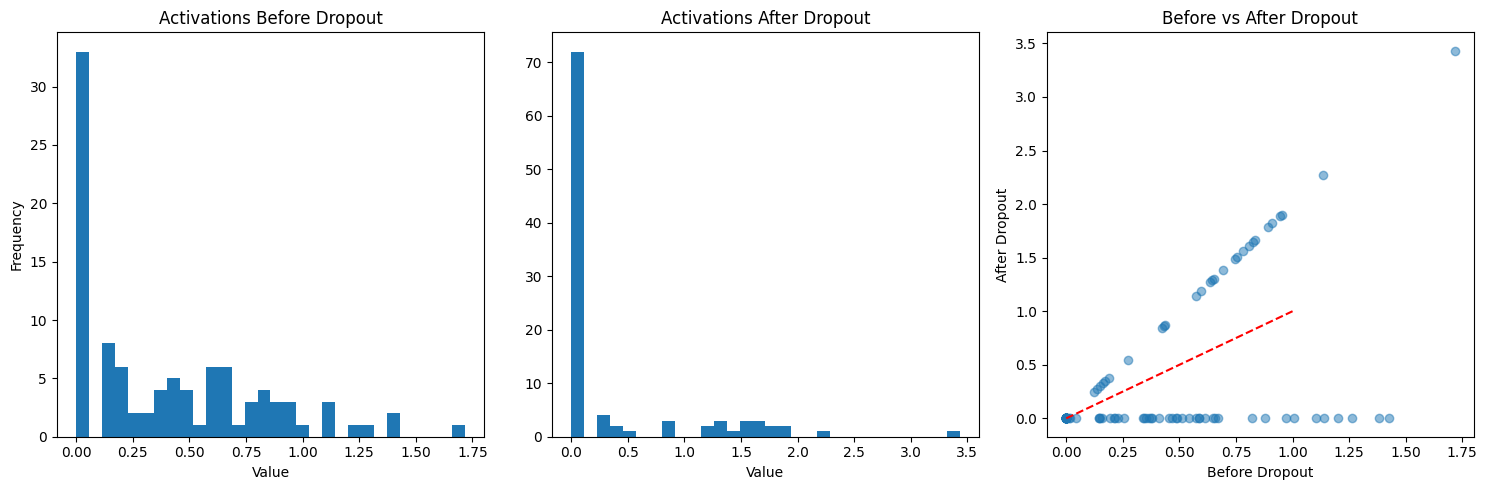


Evaluation Mode (Dropout Inactive):


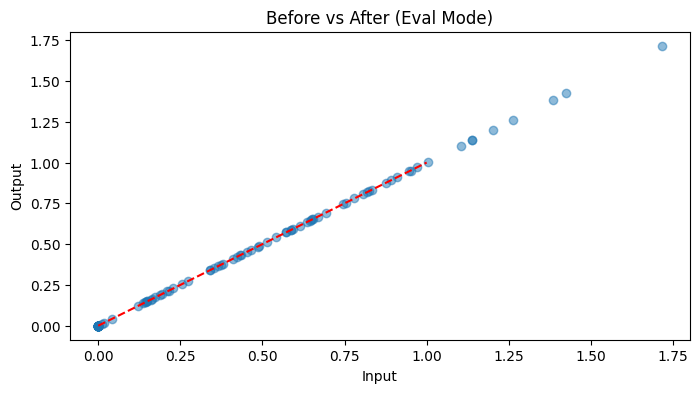

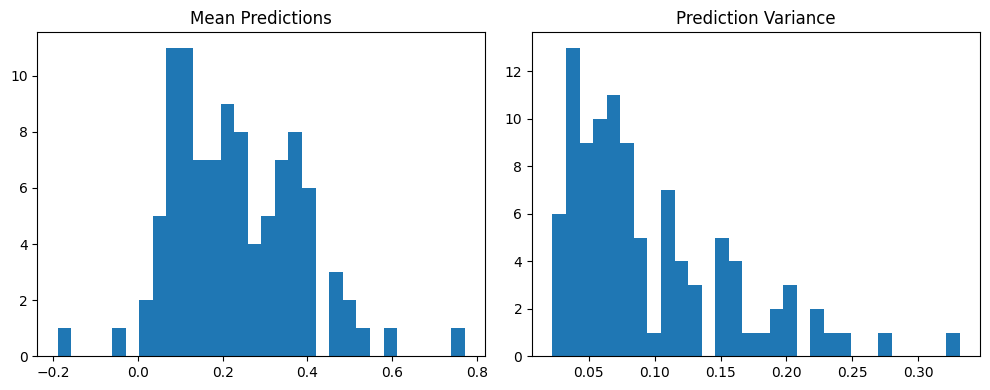

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

class DropoutDemo(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=100, output_dim=3, dropout_rate=0.5):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.layer2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, visualize=False):
        # First layer
        h1 = torch.relu(self.layer1(x))

        if visualize:
            # Store pre-dropout activations
            self.pre_dropout = h1.detach().clone()

        # Apply dropout
        h1_dropout = self.dropout(h1)

        if visualize:
            # Store post-dropout activations
            self.post_dropout = h1_dropout.detach().clone()

        # Output layer
        out = self.layer2(h1_dropout)
        return out

# Create sample data
np.random.seed(42)
X = torch.randn(100, 2)  # 100 samples, 2 features

# Initialize model
model = DropoutDemo()

# Visualization function
def visualize_dropout_effect():
    model.train()  # Set to training mode
    out = model(X, visualize=True)

    # Plot activations before and after dropout
    plt.figure(figsize=(15, 5))

    # Original activations
    plt.subplot(131)
    plt.hist(model.pre_dropout[:, 0].numpy(), bins=30)
    plt.title('Activations Before Dropout')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # After dropout
    plt.subplot(132)
    plt.hist(model.post_dropout[:, 0].numpy(), bins=30)
    plt.title('Activations After Dropout')
    plt.xlabel('Value')

    # Compare distributions
    plt.subplot(133)
    plt.scatter(model.pre_dropout[:, 0], model.post_dropout[:, 0], alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--')  # diagonal line
    plt.title('Before vs After Dropout')
    plt.xlabel('Before Dropout')
    plt.ylabel('After Dropout')

    plt.tight_layout()
    plt.show()

# Visualize effect during training
print("Training Mode (Dropout Active):")
visualize_dropout_effect()

# Visualize effect during inference
model.eval()  # Set to evaluation mode
print("\nEvaluation Mode (Dropout Inactive):")
_ = model(X, visualize=True)
plt.figure(figsize=(8, 4))
plt.scatter(model.pre_dropout[:, 0], model.post_dropout[:, 0], alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.title('Before vs After (Eval Mode)')
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

# Example of Monte Carlo Dropout for uncertainty estimation
def mc_dropout_predict(model, x, n_samples=100):
    model.train()  # Keep dropout active
    predictions = []

    with torch.no_grad():
        for _ in range(n_samples):
            pred = model(x)
            predictions.append(pred)

    # Stack predictions
    predictions = torch.stack(predictions)

    # Calculate mean and variance
    mean = predictions.mean(0)
    variance = predictions.var(0)

    return mean, variance

# Demonstrate MC Dropout
mean, variance = mc_dropout_predict(model, X)

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.hist(mean[:, 0].numpy(), bins=30)
plt.title('Mean Predictions')
plt.subplot(122)
plt.hist(variance[:, 0].numpy(), bins=30)
plt.title('Prediction Variance')
plt.tight_layout()
plt.show()